In [6]:
# essentially this hw is the same as last time but with regressors rather than classifiers
# remember to use MSE rather than accuracy
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor
from sklearn.base import clone
from numpy import linalg
from scipy import stats
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import random
from math import log2


def lr_regressor(X,y, SEED):
#     clf = RandomForestClassifier(max_depth=2, random_state=0)
#     clf.fit(X, y)
    #print(SEED)
    reg = LinearRegression()
    reg.fit(X, y)
    return reg

def partition_data(data, indices):
    X, y = [], []
    for index in indices:
        X.append(data[index, :-1])
        y.append(data[index, -1])
    return np.array(X), np.array(y)

    
def update_indices(indices, remaining_indices, dataset, clf, TYPE):
    # need to apply the remaining_indices to the data
    train_X, train_y = partition_data(dataset, indices)
    test_X, test_y = partition_data(dataset, remaining_indices)
    if TYPE == "random":
        next_index = random.choice(remaining_indices)
    elif TYPE == "uncertainty":
        next_datapoint = uncertainty_sampling(clf, train_X, train_y, test_X)
        next_index = np.where(dataset[:, :-1]==next_datapoint)[0][0]
    elif TYPE == "density":
        next_datapoint = density_sampling(clf, train_X, train_y, test_X)
        next_index = np.where(dataset[:, :-1]==next_datapoint)[0][0]
    elif TYPE == "qbc":
        next_datapoint = qbc(clf, train_X, train_y, test_X)
        next_index = np.where(dataset[:, :-1]==next_datapoint)[0][0]
    elif TYPE == "model change":
        next_datapoint = model_change(clf, train_X, train_y, test_X)
        next_index = np.where(dataset[:, :-1]==next_datapoint)[0][0]
    elif TYPE == "mellow uncertainty":
        next_datapoint = mellow_uncertainty_sampling(clf, test_X)
        next_index = np.where(dataset[:, :-1]==next_datapoint)[0][0]
    indices.append(next_index)
    remaining_indices.remove(next_index)
    return indices, remaining_indices

def train_regressor(c_train_X, c_train_y, c_test_X, c_test_y, SEED, CV=False):
    if CV == True:
        # cross validation goes here
        kf = KFold(n_splits=5)
        split_mses = []
        for train_index, test_index in kf.split(c_train_X, c_train_y):
            # train estimator
            rf_r = lr_regressor(c_train_X[train_index], c_train_y[train_index], SEED)
            # evaluate cv -- train means cv here because I am dumb
            split_mses.append(mean_squared_error(c_train_y[test_index], rf_r.predict(c_train_X[test_index])))
        rf_c = lr_regressor(c_train_X, c_train_y, SEED)
        CV_mse = np.mean(split_mses)
        return CV_mse, rf_c
    else:
        rf_c = lr_regressor(c_train_X, c_train_y, SEED)
        all_data_mse = mean_squared_error(c_test_y, rf_c.predict(c_test_X))
        return all_data_mse, rf_c

def split_train_test(classification_data, indices, remaining_indices, SEED, CV):
    c_train_X, c_train_y = partition_data(classification_data, indices)
    c_test_X, c_test_y = partition_data(classification_data, remaining_indices)

    all_data_acc, clf = train_regressor(c_train_X, c_train_y, c_test_X, c_test_y, SEED, CV)
    return all_data_acc, clf

def one_sim(indices, remaining_indices, classification_data, clf, TYPE, SEED, all_data_accs, CV):
    while len(indices) < 50:
        indices, remaining_indices = update_indices(indices, remaining_indices,classification_data, clf, TYPE)
        # now I need to maintain some if statements
        # retrain each model 
        all_data_acc, clf = split_train_test(classification_data, indices, remaining_indices, SEED, CV)
        all_data_accs.append(all_data_acc)
    return (all_data_accs)
    

# uncertainty clf, data_X
def uncertainty_sampling(reg, X_train, y_train, X_test):
    # get std_dev of old points
    var = sum((reg.predict(X_train) - y_train)**2) / (len(y_train) - 2)
    # now calc prediction interval
    train_mean = np.mean(X_train)
    sum_dists = np.sum([(point-train_mean)**2 for point in X_train])
    n = X_train.shape[0]
    PI_ranges = []
    for new_point in X_test:
        sum_dist_from_new = np.sum([(point-new_point)**2 for point in X_train]) 
        pred_error = var* (sum_dist_from_new/(n*sum_dists) + 1)
        # assuming a 95% PI, the z_alpha/2 = 1.96
        prediction_interval = (reg.predict([new_point]) - 1.96*np.sqrt(pred_error), 
                              reg.predict([new_point]) + 1.96*np.sqrt(pred_error))
        PI_range = abs(prediction_interval[0] - prediction_interval[1])
        PI_ranges.append(PI_range)
    #print(X_test.shape, )
    return X_test[np.argmax(PI_ranges)]


# density
# need 
def utility(reg, X_train, y_train, new_point):
    # get std_dev of old points
    var = sum((reg.predict(X_train) - y_train)**2) / (len(y_train) - 2)
    # now calc prediction interval
    train_mean = np.mean(X_train)
    sum_dists = np.sum([(point-train_mean)**2 for point in X_train])
    n = X_train.shape[0]
    sum_dist_from_new = np.sum([(point-new_point)**2 for point in X_train]) 
    pred_error = var * (sum_dist_from_new/(n*sum_dists) + 1)
    # assuming a 95% PI, the z_alpha/2 = 1.96
    prediction_interval = (reg.predict([new_point]) - 1.96*np.sqrt(pred_error), 
                          reg.predict([new_point]) + 1.96*np.sqrt(pred_error))
    PI_range = abs(prediction_interval[0] - prediction_interval[1])
    return PI_range
    
    
def inv_dist(x, y):
    dist = np.linalg.norm(x-y)
    # if 0 then it's the same point, no similarity bcuz we shouldn't count it
    if (dist) == 0:
        return 0
    else: 
        return 1/dist

def density_sampling(reg, X_train, y_train, data):
    # we'll say beta = 1
    # argmax is wrt  x
    # if beta =1, then (1/data.shape[0]) is just some scalar and does not influence the argmax, don't need it
    return(data[np.argmax([utility(reg, X_train, y_train, data[x,:])*np.sum([inv_dist(data[x,:],data[y,:]) for y in range(data.shape[0])]) for x in range(data.shape[0])])])

# qbc
# clf, train_X, train_y, test_X
def qbc(clf, X, y, data):
    # add bagging but for regressor
    reg = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=10, random_state=0)
    reg.fit(X, y)
    # maximize the variance between the predicted y's amongst all the estimators
    pred_y_vects = []
    for estimator in reg.estimators_:
        pred_y_vect = estimator.predict(data)
        pred_y_vects.append(pred_y_vect)
    pred_y_vects = np.column_stack(pred_y_vects)
    mean_y = np.mean(pred_y_vects, axis=1) # want this to be a 95 long 1d array
    sum_dists = [(np.linalg.norm(pred_y_vects[:,i]-mean_y)) for i in range(pred_y_vects.shape[1])]
    return data[np.argmax(sum_dists)]

    
def model_change(reg, X_train, y_train, data_X):
    # need gradient, f-norm of gradient, how do I replace the class probabilities here? -- the PIs
    # X, y are prev
    # data_X are possible new points
    all_x_gradients = []
    poss_y = [0, 1]
    # gradient for linear regression = just the coeffs?
    for x in data_X:
        # add point, compute new gradient
        tenative_X = np.row_stack((X_train, x))
        tenative_y = np.append(y_train, reg.predict([x]))
        grad1 = (-2/tenative_X.shape[0]) * np.sum([tenative_X[i]*(tenative_y[i]-((reg.coef_*tenative_X[i])+reg.intercept_)) for i in range(tenative_X.shape[0])])
        grad2 = (-2/tenative_X.shape[0]) * np.sum([tenative_y[i]-((reg.coef_*tenative_X[i])+reg.intercept_) for i in range(tenative_X.shape[0])])
        grad = np.array(grad1, grad2)
        # pred y given a new x
        pred_y = reg.predict([x])
        reg1 = clone(reg)
        new_reg = reg1.fit([x], [pred_y])
        p = mean_squared_error(new_reg.predict([x]), [np.mean(np.append(y_train, [pred_y]))])
        mean_y = [np.mean(y_train)]
        p = (np.sum(mean_squared_error(y_train, X_train.shape[0]* mean_y))+p)/ (X_train.shape[0] + 1)
        #print(p, y_train, X_train.shape[0]*[mean_y])
        x_grad = p*linalg.norm(grad)
        all_x_gradients.append(x_grad)

    return data_X[np.argmax(all_x_gradients)]


# make this function flexible
def simulations(NUM_SIMS, classification_data, TYPE_ls, CV, starting_point_number, number_of_iterations, DOE=False):
    SEEDs = [3, 5, 6, 7, 14, 16, 19, 21, 23, 24] # 3, 5, 6, 7, 14, 16, 19, 21, 23, 24  is good
    allTYPE_allsim_acc = []
    # if DOE equal to True, then redo every sampling type in type list with the DOE start
    for i in range(NUM_SIMS):
        SEED = SEEDs[i]
        random.seed(SEED)
        orig_indices, orig_remaining_indices = [random.randrange(100) for i in range(starting_point_number)], [i for i in range (100)]
        orig_remaining_indices = [elem for elem in orig_remaining_indices if elem not in orig_indices]
        # randomly split the data into an init 5 points --same for all sims
        indices, remaining_indices = orig_indices.copy(), orig_remaining_indices.copy()
        # get the output accs
        all_data_acc, clf = split_train_test(classification_data, indices, remaining_indices, SEED, CV)
        all_data_accs = [[all_data_acc] for i in range(len(TYPE_ls))]
        for i in range(len(TYPE_ls)):
            # indices, remaining_indices,classification_data, clf, TYPE
            all_data_accs[i]=one_sim(indices, remaining_indices, classification_data, clf, TYPE_ls[i], SEED, all_data_accs[i], CV)
            indices, remaining_indices = orig_indices.copy(), orig_remaining_indices.copy()
        # append everything -- these should be 2D lists at this point
        allTYPE_allsim_acc.append(np.array(all_data_accs))
        if DOE == True:
            orig_remaining_indices =  [i for i in range (100)]
            X,y = partition_data(classification_data, orig_remaining_indices)
            orig_indices = list(d_optimality(starting_point_number, X, number_of_iterations, SEED))
            orig_remaining_indices = [elem for elem in orig_remaining_indices if elem not in orig_indices]
            # get the output accs
            all_data_acc, clf = split_train_test(classification_data, indices, remaining_indices, SEED, CV)
            all_data_accs = [[all_data_acc] for i in range(len(TYPE_ls))]
            for i in range(len(TYPE_ls)):
                # indices, remaining_indices,classification_data, clf, TYPE
                all_data_accs[i]=one_sim(indices, remaining_indices, classification_data, clf, TYPE_ls[i], SEED, all_data_accs[i], CV)
                indices, remaining_indices = orig_indices.copy(), orig_remaining_indices.copy()
            # append everything -- these should be 2D lists at this point
            allTYPE_allsim_acc.append(np.array(all_data_accs))
        
    allTYPE_allsim_acc = np.array(allTYPE_allsim_acc)  
    indices = 50
    # okay so now the graphing is fucked for DOE
    
    timepoints = [i for i in range(indices-starting_point_number+1)] 
    if DOE == True:
        TYPE_ls = TYPE_ls + [i+" DOE" for i in TYPE_ls]
        for i in range(len(TYPE_ls)):
            if i >= len(TYPE_ls)/2:
                j = int(i-len(TYPE_ls)/2)
                print(j)
                mean = (np.mean(allTYPE_allsim_acc[:,j][NUM_SIMS:], axis = 0))
                std = (np.std(allTYPE_allsim_acc[:,j][NUM_SIMS:], axis = 0))
                print(mean.shape, std.shape)
                plt.errorbar(timepoints, mean, std, linestyle='None', marker='^',label=TYPE_ls[i])
            else:
                mean = (np.mean(allTYPE_allsim_acc[:,i][:NUM_SIMS], axis = 0))
                std = (np.std(allTYPE_allsim_acc[:,i][:NUM_SIMS], axis = 0))
                plt.errorbar(timepoints, mean, std, linestyle='None', marker='^',label=TYPE_ls[i])
    else:
        for i in range(len(TYPE_ls)):
            mean = (np.mean(allTYPE_allsim_acc[:,i][:NUM_SIMS], axis = 0))
            std = (np.std(allTYPE_allsim_acc[:,i][:NUM_SIMS], axis = 0))
            plt.errorbar(timepoints, mean, std, linestyle='None', marker='^',label=TYPE_ls[i])
    plt.xlabel("Number of Rounds")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    #plt.savefig(title) 
    #plt.close()
    plt.show()

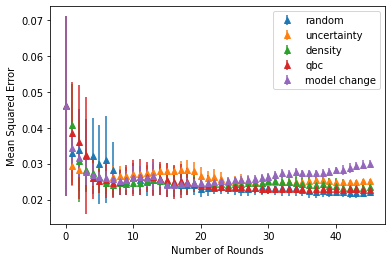

In [2]:
regression_data =np.loadtxt(open("regression.csv", "rb"), delimiter=",", skiprows=1)
TYPE_ls = ["random", "uncertainty", "density", "qbc", "model change"]
starting_point_number = 5 
number_of_iterations = 10000
simulations(10, regression_data, TYPE_ls, False, starting_point_number, number_of_iterations, False)

# describe each method with a few sentences
I implemented uncertainty sampling by using the prediction interval for linear regression. I then checked the size of the range of each interval and returned the datapoint that maximized the size of the prediction interval. If the model is more uncertain about a particular point, the PI will be larger, and vice versa if more certain. In this way you can think of my implementation as an adaption of the least confident method.

For density sampling I mostly reused my old code and simply changed out the utility function. My utility function now spits out the size of the prediction interval for the model given an input datapoint. Again, this can be thought as least confident, my adaptation of using uncertainty for this situation. 

For query by committee I maintained a set of 10 bagging regressors at each point in time. At each point in time, I trained the regressors on boostrapped subsets of the seen data, and then got the predicted y output of each regressor on all the unseen data. After doing this for all 10 regressors, I determined the mean predicted y output for each datapoint and then I choose the datapoint that had the largest total distance between the predicted ys for each estimator and the predicted y for the datapoint. In this way I choose the datapoint the bagging regressors are least sure about.

For Expected Model Change I calculated the gradient as described in the notes and used the mean of the MSE for all the seen points plus the new datapoint and it's predicted y as a proxy for summing over all p(y_i |x) for the seen data plus the new datapoint. Then I chose the datapoint that maximized that equation, as said in the notes. 


    

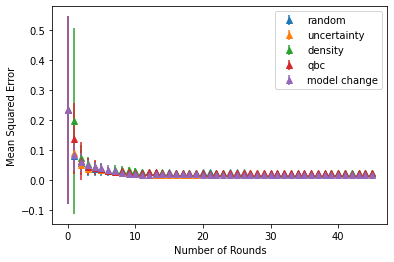

In [3]:
#  now do this again but with 5 fold cross validation
regression_data =np.loadtxt(open("regression.csv", "rb"), delimiter=",", skiprows=1)
TYPE_ls = ["random", "uncertainty", "density", "qbc", "model change"]
starting_point_number = 5
number_of_iterations = 1000
simulations(10, regression_data, TYPE_ls, True, starting_point_number, number_of_iterations, False)

No handles with labels found to put in legend.


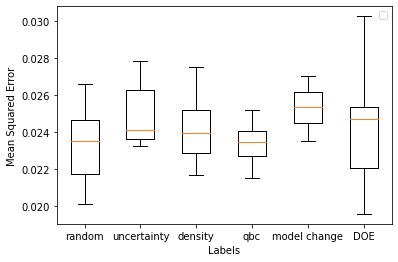

In [26]:
# then implement a DOE stategy (any one that was mentioned)
def d_optimality(k, X, number_of_iterations, SEED):
    random.seed(SEED)
    dets, datasets = [], []
    # do this some arbitrary number of times, let's just play with 100 different combos and choose 
    for i in range(number_of_iterations):
        # randomly sample without replacement k many times
        #print(len(X), k)
        indices = np.random.choice(len(X), size=k, replace=False)
        ten_x = X[indices, :]
        datasets.append(indices)
        # then compute determinant
        dets.append(np.linalg.det(ten_x.T @ ten_x))
    return datasets[np.argmax(dets)]

# 2b.  Generate a plot comparing the performance (MSE of unobserved instances) of 
# regression modeIs 
# after 30 observations on the regression dataset using the myopic active learning selection strategies in 
# Part 1 and your implemented DOE strategy from 2a.  
# If you incorporate any randomness into 2a.  Run 10 simulations of each method. 
def one_sim(indices, remaining_indices, classification_data, clf, TYPE, SEED, all_data_accs, CV):
    while len(indices) < 30:
        indices, remaining_indices = update_indices(indices, remaining_indices,classification_data, clf, TYPE)
        # now I need to maintain some if statements
        # retrain each model 
        all_data_acc, clf = split_train_test(classification_data, indices, remaining_indices, SEED, CV)
        all_data_accs.append(all_data_acc)
    return (all_data_accs)


def boxplot_simulations(NUM_SIMS, classification_data, TYPE_ls, CV, number_of_iterations):
    SEEDs = [3, 5, 6, 7, 14, 16, 19, 21, 23, 24] # 3, 5, 6, 7, 14, 16, 19, 21, 23, 24  is good
    allTYPE_allsim_acc = []
    DOE_MSEs = []
    for i in range(NUM_SIMS):
        SEED = SEEDs[i]
        random.seed(SEED)
        orig_indices, orig_remaining_indices = [random.randrange(100) for i in range(5)], [i for i in range (100)]
        orig_remaining_indices = [elem for elem in orig_remaining_indices if elem not in orig_indices]
        # randomly split the data into an init 5 points --same for all sims
        indices, remaining_indices = orig_indices.copy(), orig_remaining_indices.copy()
        # get the output accs
        all_data_acc, clf = split_train_test(classification_data, indices, remaining_indices, SEED, CV)
        all_data_accs = [[all_data_acc] for i in range(len(TYPE_ls))]
        for i in range(len(TYPE_ls)):
            # indices, remaining_indices,classification_data, clf, TYPE
            all_data_accs[i]=one_sim(indices, remaining_indices, classification_data, clf, TYPE_ls[i], SEED, all_data_accs[i], CV)
            indices, remaining_indices = orig_indices.copy(), orig_remaining_indices.copy()
        # append everything -- these should be 2D lists at this point
        allTYPE_allsim_acc.append(np.array(all_data_accs))
        # then do DOE
        k = 30
        orig_remaining_indices = [i for i in range (100)]
        X, y = partition_data(classification_data, orig_remaining_indices)
        indices = d_optimality(k, X, number_of_iterations, SEED)
        # need to be able to partition the dataset 
        new_X, new_y = partition_data(classification_data, indices)
        orig_remaining_indices = [elem for elem in orig_remaining_indices if elem not in indices]
        remaining_X, remaining_y = partition_data(classification_data, orig_remaining_indices)
        # use these points to fit the reg
        reg = lr_regressor(new_X, new_y, SEED)
        # then calculate MSE on rest of the dataset -- append this to the list of MSEs
        DOE_MSEs.append(mean_squared_error(remaining_y, reg.predict(remaining_X)))
        
    allTYPE_allsim_acc = np.array(allTYPE_allsim_acc)  
    #raise error
    # now rip this out and change it to a box and whisker
    # now grab the specifics for each
    # grab the last point for each type across all simulations
    data = (allTYPE_allsim_acc[:,:, -1])
    data = np.column_stack((data, DOE_MSEs))
    TYPE_ls = TYPE_ls + ["DOE"]
    plt.boxplot(data, labels=TYPE_ls)
    plt.xlabel("Labels")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    #plt.savefig(title) 
    #plt.close()
    plt.show()

# set k=30, and pick 30 with each 
regression_data =np.loadtxt(open("regression.csv", "rb"), delimiter=",", skiprows=1)
TYPE_ls = ["random", "uncertainty", "density", "qbc", "model change"]
number_of_iterations = 1000000
#title = "MSE_HW3_3.pdf"
boxplot_simulations(10, regression_data, TYPE_ls, False, number_of_iterations)
# he wants a box and whisker plot here

0
(41,) (41,)


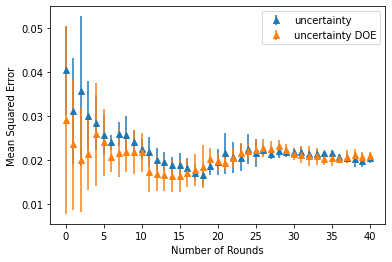

In [7]:
# Run active learning simulations using uncertainty sampling and your favorite regressor on the 
# regression dataset.  For one set of simulations, initialize with 10 randomly selected instances.  
# For another set of simulations, initialize with 10 DOE selected instances.  
# Continue both types of simulations until 50 instances are observed.  
# In a single plot, show the mean square error (and standard deviation) of 
# predictions on the unobserved set as a function of the number of instances observed.

regression_data =np.loadtxt(open("regression.csv", "rb"), delimiter=",", skiprows=1)
TYPE_ls = ["uncertainty"]
starting_point_number = 10
number_of_iterations = 100000
#title = "MSE_HW3_4.pdf"
simulations(10, regression_data, TYPE_ls, True, starting_point_number, number_of_iterations, True)

No handles with labels found to put in legend.


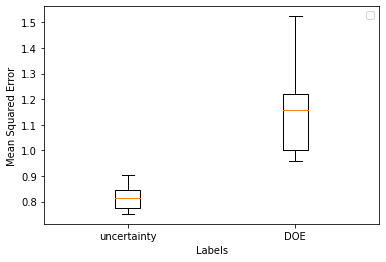

In [21]:
# 4a.  Generate your own regression dataset of 100 instances where the performance of active learning in 
# part 2 (choose your favorite AL method) is better than the performance of DOE.  
# Show MSE for both methods at 30 observations. -- inject high variance and DOE should crumble
from sklearn.datasets import make_regression
X,y  = make_regression(n_samples=100, n_features=10, n_informative=10, n_targets=1, bias=0.0, 
                                 effective_rank=10, tail_strength=2, noise=1.0, shuffle=True, coef=False, 
                                 random_state=6)
y = np.reshape(y, (100, 1))    
data = np.hstack((X, y))
# set k=30, and pick 30 with each 
TYPE_ls = ["uncertainty"]
number_of_iterations = 1000
#title = "MSE_HW3_5.pdf"
boxplot_simulations(10, data, TYPE_ls, False, number_of_iterations)

I jacked up the effective_rank, noise, and tail strength, and this seems to have messed up the D-optimality. The noise just gives better separation between the slight difference in the models, the thing that kills D-optimality is the imbalance in the noise through increasing the tail strength. The high effective rank also seems to help by making the regressor work harder on the data, but this is more constant amongst the datapoints it seems, so it isn't enough alone. The inconstant noise between datapoints violates the assumptions of D-optimaliity and makes it worse.

No handles with labels found to put in legend.


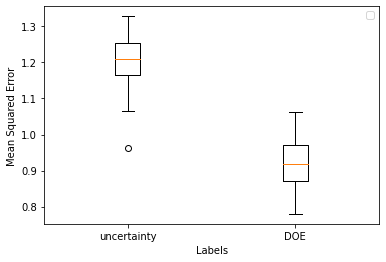

In [24]:
# 4b.  Generate your own regression dataset of 100 instances where the performance of active learning in 
# part 2 (choose the same AL method as in part 4a) is worse than the performance of DOE.  Show MSE for both 
# methods at 30 observations.
# lol this part is easy

from sklearn.datasets import make_regression
X,y  = make_regression(n_samples=100, n_features=10, n_informative=10, n_targets=1, bias=0.0, 
                                 effective_rank=1, tail_strength=0.0, noise=1.0, shuffle=True, coef=False, 
                                 random_state=6)
y = np.reshape(y, (100, 1))    
data = np.hstack((X, y))
# set k=30, and pick 30 with each 
TYPE_ls = ["uncertainty"]
number_of_iterations = 10000
#title = "MSE_HW3_6.pdf"
boxplot_simulations(10, data, TYPE_ls, False, number_of_iterations)


4c.  Comment on the differences in the datasets and why you think those differences contributed to differences in learning performance.

Here it's pretty much the opposite, I gave it no tail so the noise is more or less constant between datapoints. I also lowered the effective rank, which seems to make the results more clear. Now DOE consistently beats uncertainty because its assumptions are valid, and so it performs as expected. 